# 9.1 Experiencing ROS2

This is the end of our journey!. And last but not least... we're going to experience the amazing [Robot Operating System 2 (ROS2) ecosystem](https://docs.ros.org/en/humble/index.html).

For that, we are going to use the [MVSim](https://mvsimulator.readthedocs.io/en/latest/index.html), a lightweight MultiVehicle Simulator: 

> Lightweight, realistic dynamical simulator for 2D (“2.5D”) vehicles and robots. It is tailored to analysis of vehicle dynamics, wheel-ground contact forces, and accurate simulation of typical robot sensors.
This project includes C++ and Python libraries, the standalone CLI application mvsim, and ROS 1 and ROS 2 nodes, and it is licensed under the permissive 3-clause BSD License.

<center><video width=" " height=" " 
       src="./images/mvsim_demo_greenhouse.mp4"  
       controls>
</video></center>

## 9.1.1 Preparing the path

For working with ROS2 and MVSim you will need:
- Ubuntu 22.04 (you can natively install it, or through a Virtual Machine (e.g., VMWare or WSL).
- ROS2 (https://docs.ros.org/en/humble/Installation/Ubuntu-Install-Debians.html). You will need both the *Desktop installation* and *Development tools*.
- MVSim (https://mvsimulator.readthedocs.io/en/latest/install.html).

**<font color="red">Important!</font>** ROS2 relies on a number of environment variables to work properly, so we need to load them in our terminal. This can be done through the `source` command, which executes the commands from a file in the current shell:

```bash
source /opt/ros/humble/setup.bash 
```

However, executing the command in that manner requires you to load the variables each time you open a new terminal. To solve this, you can add the `source` command to your `.bashrc` file, which is automatically executed every time a new terminal session is started, ensuring that the necessary variables are consistently loaded:

```bash
echo "source /opt/ros/humble/setup.bash" >> ~/.bashrc
```

Later on you will repeat this but with the environment variables of your workspace.

You can also install terminator for managing terminals:

```bash
sudo apt install terminator
```

## 9.1.2 Insight into MVSim

MVSim simulates a world as defined in a `.world` file. It could be illustrative to take a look at any of them, hey are placed at: `/opt/ros/humble/share/mvsim/mvsim_tutorial`. This file tells MVSim everything about the world, from obstacles, to robots, sensors, and other objects in the virtual environment. Depending on the world you are running, the available topics can change. 

<center><video width=" " height=" " 
       src="./images/mvsim_demo_1robot.mp4"  
       controls>
</video></center>

The following is an example for the world shown above:

```xml
    <mvsim_world version="1.0">
        <!-- General simulation options -->
        <simul_timestep>0</simul_timestep> <!-- Simulation fixed-time interval for numerical integration [seconds] or 0 to autodetermine -->

        <!-- GUI options -->
        <gui>
                <ortho>false</ortho>
                <show_forces>true</show_forces>  <force_scale>0.01</force_scale>
                <cam_distance>35</cam_distance>
                <fov_deg>60</fov_deg>
                <refresh_fps>20</refresh_fps>
                <!-- <follow_vehicle>r1</follow_vehicle> -->
        </gui>

        <!-- Light parameters -->
        <lights>
        </lights>

        <!-- ========================
                   Scenario definition
             ======================== -->
        <element class="occupancy_grid">
                <!-- File can be an image or an MRPT .gridmap file -->
                <file>uma_campus.gridmap.gz</file>

                <!--<show_collisions>true</show_collisions>-->
        </element>

        <!-- ground grid (for visual reference) -->
        <element class="ground_grid">
                <floating>true</floating>
        </element>

        <!-- =============================
                   Vehicle classes definition
             ============================= -->
        <include file="../definitions/ackermann.vehicle.xml" />

        <!-- ========================
                   Vehicle(s) definition
             ======================== -->
        <vehicle name="r1" class="car_ackermann">
                <init_pose>0 0 0</init_pose>  <!-- In global coords: x,y, yaw(deg) -->
                <init_vel>0 0 0</init_vel>  <!-- In local coords: vx,vy, omega(deg/s) -->

                <!-- Sensors -->
                <include file="../definitions/lidar2d.sensor.xml" sensor_x="1.7" sensor_z="1.01" sensor_yaw="0" max_range="70.0" sensor_name="laser1" />
                <include file="../definitions/lidar2d.sensor.xml" sensor_x="-0.5" sensor_z="1.01" sensor_yaw="180" max_range="70.    0" sensor_name
```>
</launch>="laser2" />
        </vehicle>

</mvsim_world>

MVSim also comes with a number of launch files for working with these demo worlds. For example, `demo_1robot.launch`:

```xml
<?xml version="1.0"?>
<!-- ROS1 launch file. See *.launch.py files for ROS2 launch files -->
<launch>
        <arg name="world_file" default="$(find mvsim)/mvsim_tutorial/demo_1robot.world.xml" />
        <arg name="mvsim_do_fake_localization" default="true"/>

        <node pkg="mvsim" type="mvsim_node" name="mvsim_simulator" output="screen">
                <param name="world_file" value="$(arg world_file)"/>
                <param name="do_fake_localization" value="$(arg mvsim_do_fake_localization)"/>
        </node>

        <node pkg="rviz" type="rviz" name="rviz" args="-d $(find mvsim)/mvsim_tutorial/demo_1robot.rviz"/>
</launch>
```

With its python-based counterpart:

```python
# ROS2 launch file

from launch import LaunchDescription
from launch.substitutions import TextSubstitution
from launch.substitutions import LaunchConfiguration
from launch_ros.actions import Node
from launch.actions import DeclareLaunchArgument
from ament_index_python import get_package_share_directory
import os


def generate_launch_description():
    mvsimDir = get_package_share_directory("mvsim")
    #print('mvsimDir: ' + mvsimDir)

    # args that can be set from the command line or a default will be used
    world_file_launch_arg = DeclareLaunchArgument(
        "world_file", default_value=TextSubstitution(
            text=os.path.join(mvsimDir, 'mvsim_tutorial', 'demo_1robot.world.xml')))

    mvsim_node = Node(
        package='mvsim',
        executable='mvsim_node',
        name='mvsim',
        output='screen',
        parameters=[
            os.path.join(mvsimDir, 'mvsim_tutorial', 'mvsim_ros2_params.yaml'),
            {
                "world_file": LaunchConfiguration('world_file'),
            }]
    )

    rviz2_node = Node(
        package='rviz2',
        executable='rviz2',
        name='rviz2',
        arguments=[
                '-d', [os.path.join(mvsimDir, 'mvsim_tutorial', 'demo_1robot_ros2.rviz')]]
    )

    return LaunchDescription([
        world_file_launch_arg,
        mvsim_node,
        rviz2_node
    ])
```

### **<span style="color:green"><b><i>ASSIGNMENT 1: Analyzing topics</i></b></span>** 

**What to do?**

- Run the demo world with a robot with `ros2 launch mvsim demo_1robot.launch.py`
- Check the available topics and include them in a list below, also stating which nodes publish/subscribes to them (rqt_graph can help here).

<p style="margin: 4px 0px 6px 5px; color:blue"><i>Los topics pueden verse con el comando "ros2 node info /mvsim"</i></p>
<img src='./images/Task1_All.png'></img>

<p style="margin: 4px 0px 6px 5px; color:blue"><i>Los cuales generan el siguiente árbol:</i></p>
<img src='./images/Task1_TreeAll.png'></img>

<p style="margin: 4px 0px 6px 5px; color:blue"><i>En vista simplificada:</i></p>
<img src='./images/Task1.png'></img>


### **<span style="color:green"><b><i>ASSIGNMENT 2: Manually controlling the robot</i></b></span>** 

One of the topics MVSim is suscribed to is `/cmd_vel`, so we can send motion commands to the robot:

```bash
ros2 topic pub /cmd_vel geometry_msgs/msg/Twist "{linear: {x: 0.5, y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: 0.0}}"
```

**What to do?**

- Send some motion commands, and take some screenshots of them and the robot. You can send a motion command full of zeros to stop it!

Take care commanding the robot, it can crash otherwise!
<p style="margin: 4px 0px 6px 5px; color:blue"><i>Comenzamos haciendo que el robot avance por el pasillo. Después girará a la izquierda y como el giro no es del todo preciso (no es de 90º) cuando retome su camino en línea recta se chocará con la pared. También hay que destacar que en su camino a chocarse detectará un pilar que ligeramente modificará su trayectoria, puesto que lo evitará en cierta medida.</i></p>

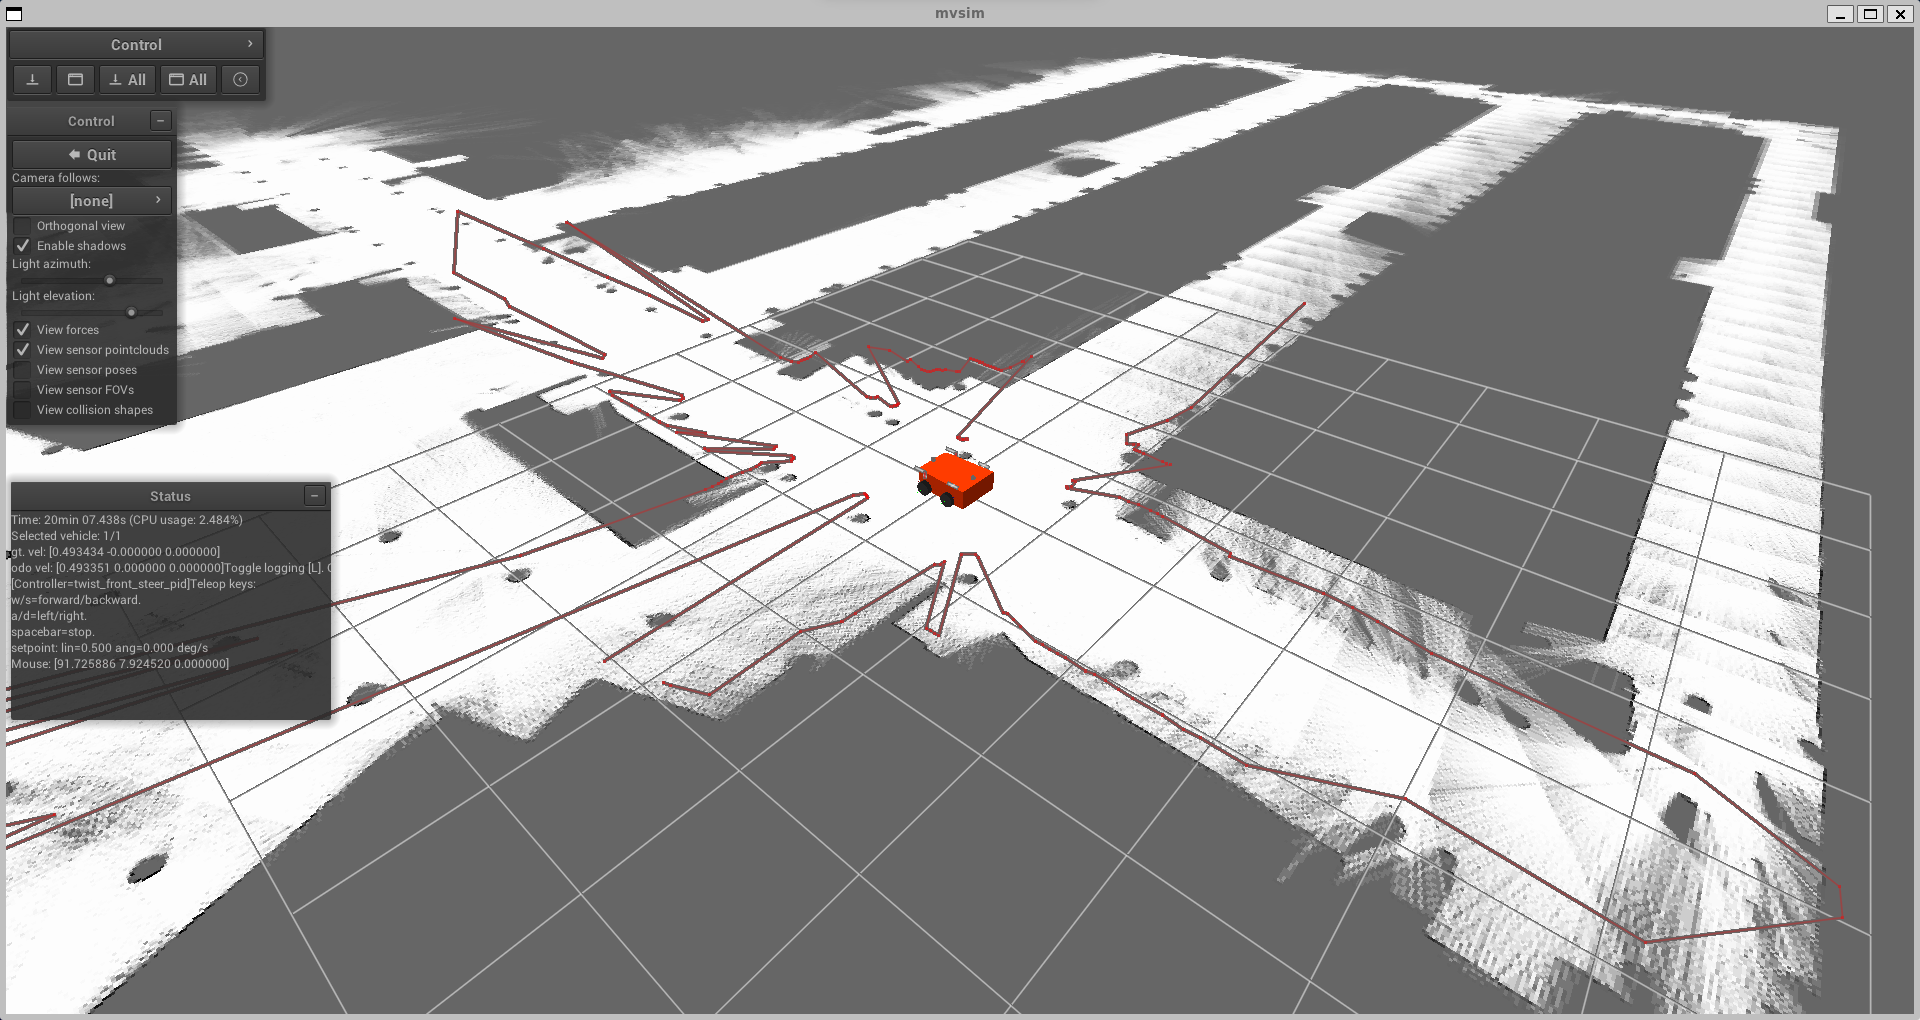

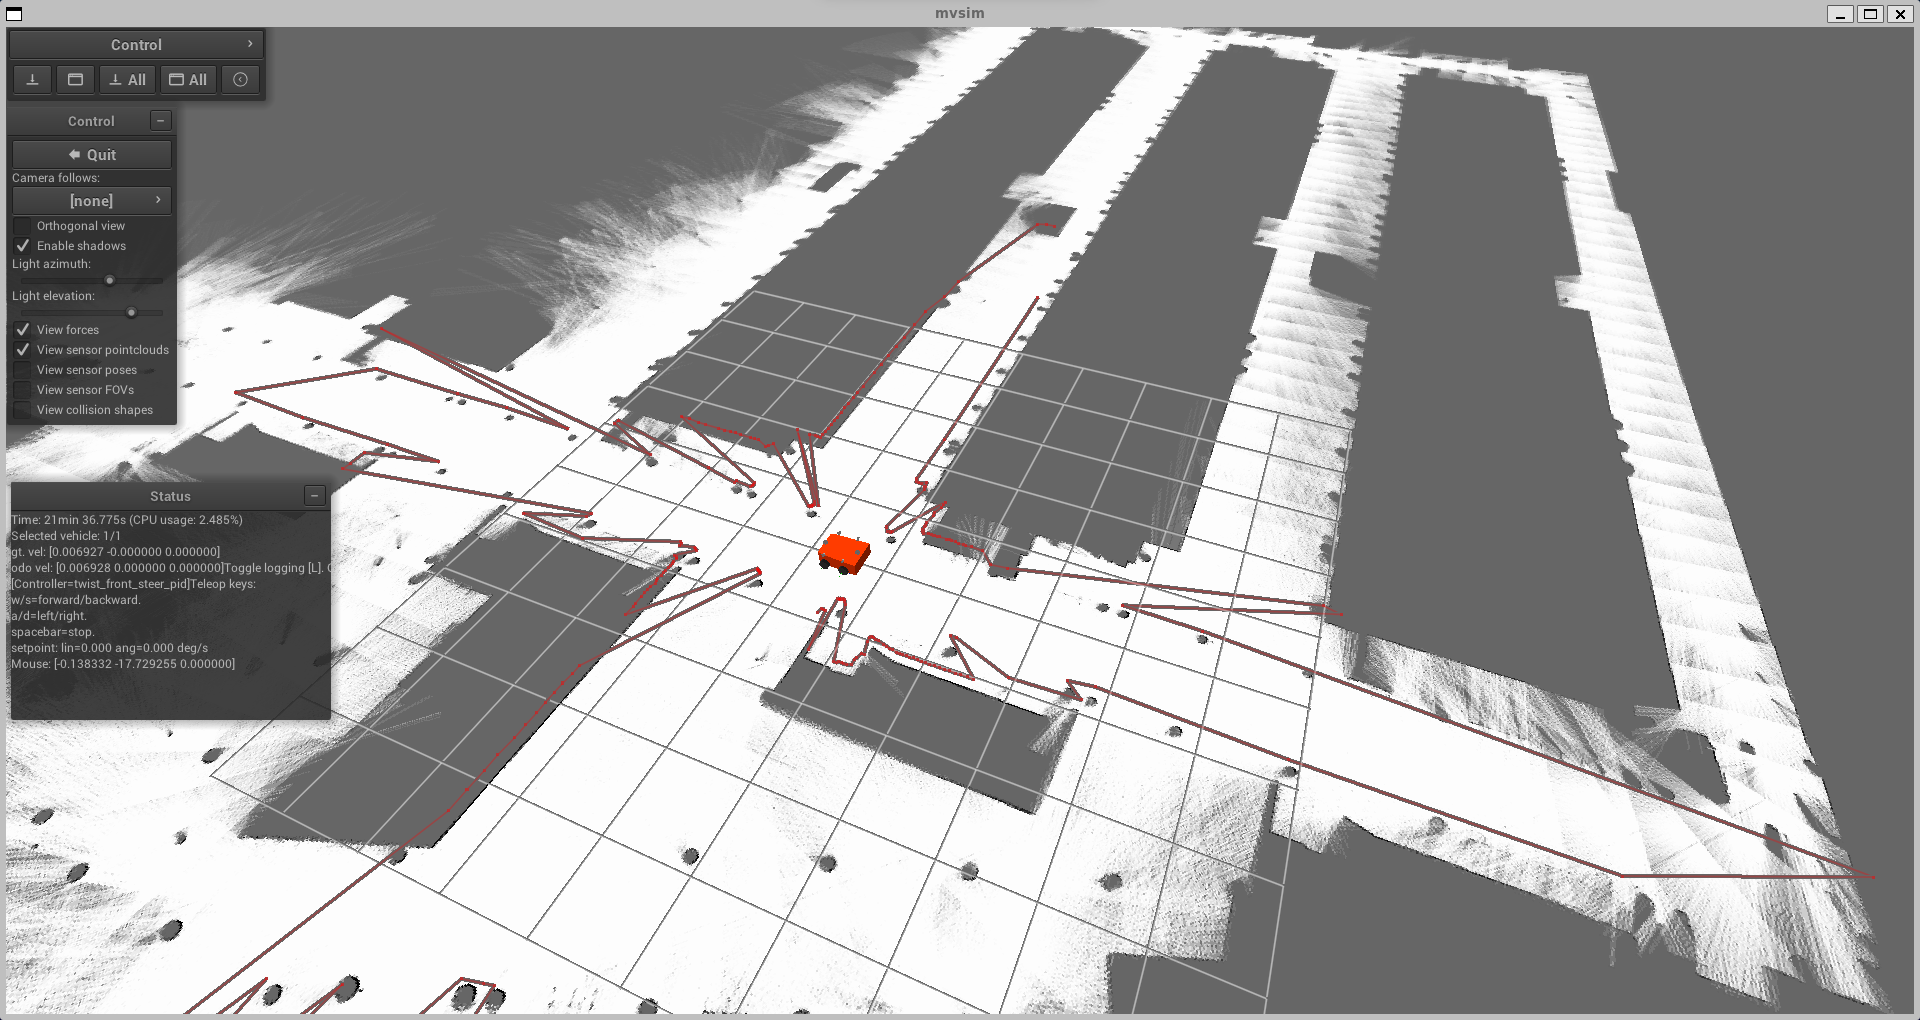

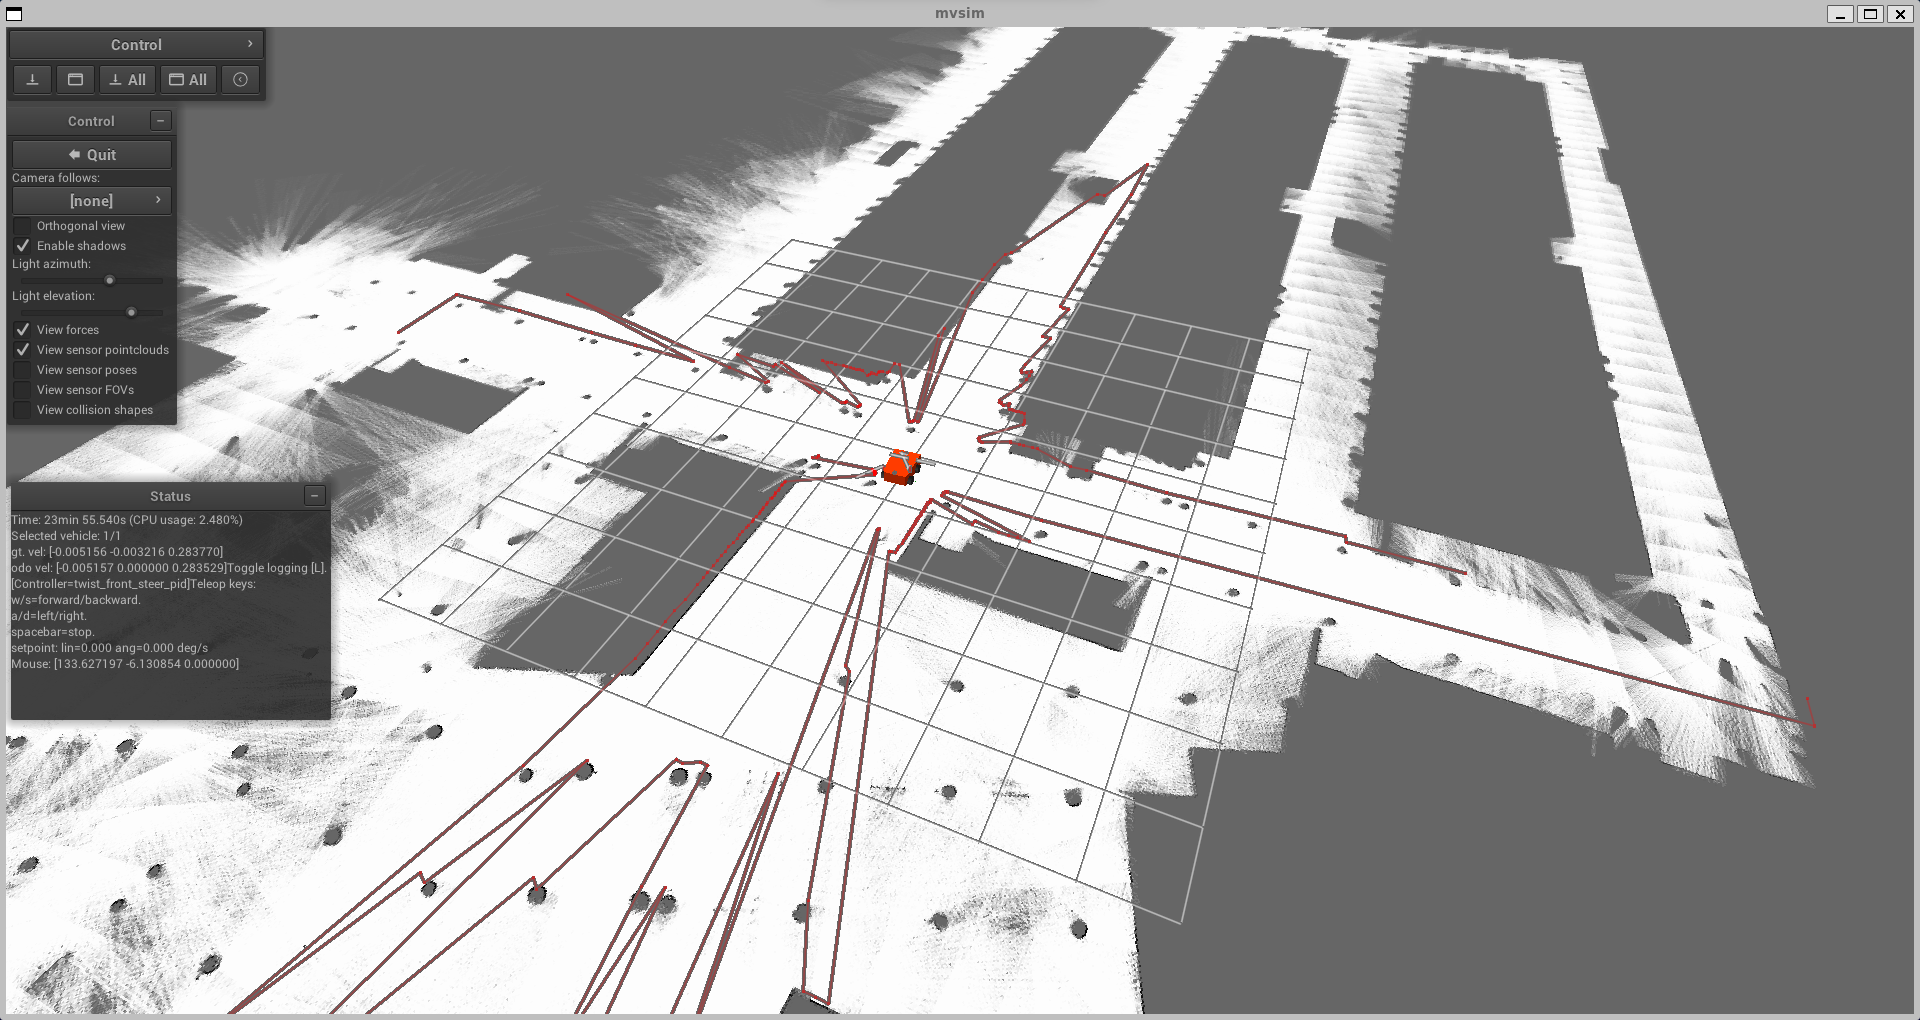

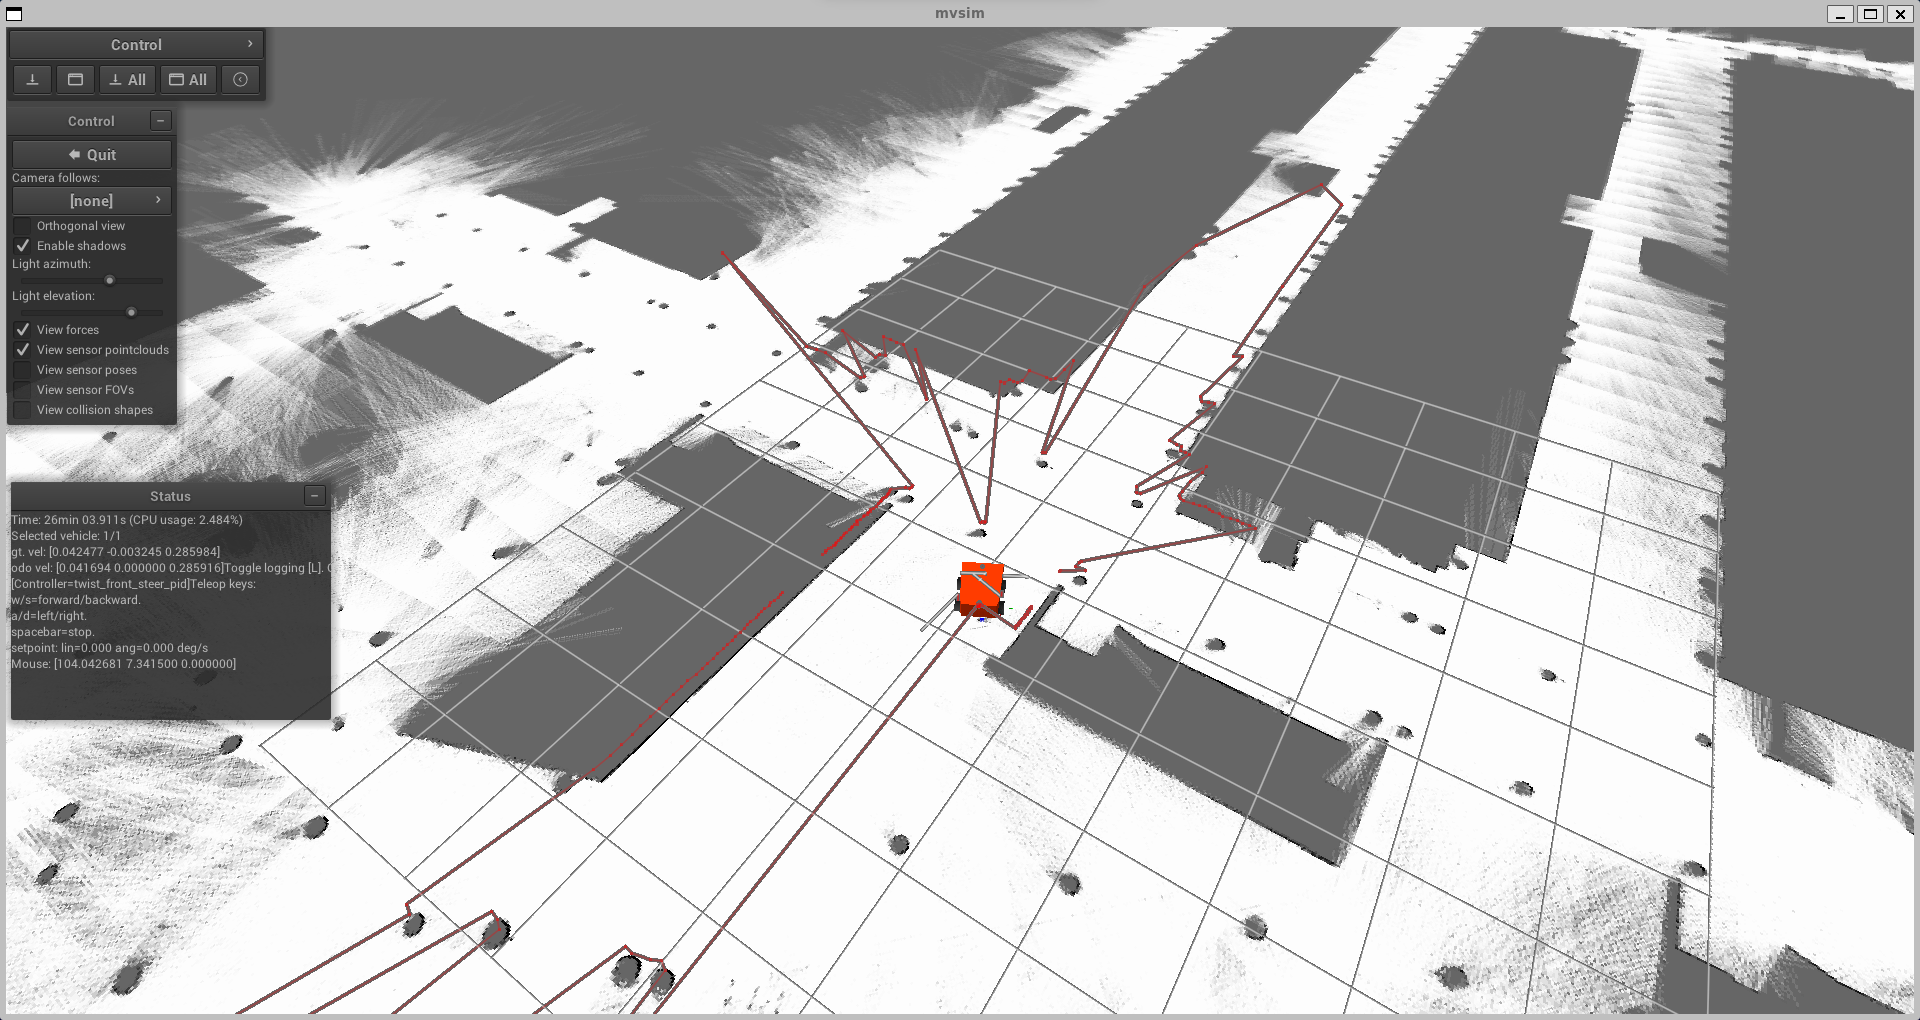



### **<span style="color:green"><b><i>ASSIGNMENT 3: Implementing reactive navigation</i></b></span>** 

Finally, we are going to implement a reactive navigation technique so our robot can safely move through the environment. Recall this pipeline when developing ROS 2 software:

![image.png](attachment:65879ebf-a37e-49a9-a5e3-8bacf2e26a49.png)

Some handy ROS 2 links: 
- [Workspace creation tutorial](https://docs.ros.org/en/humble/Tutorials/Beginner-Client-Libraries/Creating-A-Workspace/Creating-A-Workspace.html)
- [Package creation tutorial](https://docs.ros.org/en/humble/Tutorials/Beginner-Client-Libraries/Creating-Your-First-ROS2-Package.html)
- [Example of a simple publisher and subscriber](https://docs.ros.org/en/humble/Tutorials/Beginner-Client-Libraries/Writing-A-Simple-Py-Publisher-And-Subscriber.html)
- [List of ROS 2 tutorials](https://docs.ros.org/en/humble/Tutorials.html)

**What to do?**

1. Create a **ROS 2 workspace**.
   - Once created, add its `setup.bash`file to your shell configuration: `echo "source ~/humble_ws/install/setup.bash" >> ~/.bashrc`
2. Create a **package** (it can be python or c++ based). The name is of your choice!
   - CAUTION! this has to be done in the ``src`` directory of your workspace.
   - Customize the ``package.xml`` file.
3. Craete a **node**, and implement in it the Potential Fields technique we played with in the last practical session. For example, the next line creates a package called `reactive_nav` with a node named `potential_fields_nav`, using `ament_python` to specify that it will be a Python package:
```bash
ros2 pkg create --build-type ament_python --node-name potential_fields_nav reactive_nav
``` 

During the node implementation notice that:
- You can perceive the environment through the information provided by the laser. This is a **subscription**.
- You can also send motion commands. Here the node plays the role of a **publisher**.
- The robot true pose is also provided to you in a topic (`/base_pose_ground_truth`). Second **subscription**.
- You can use RViz to listen to new goal destinations through the `/goal_pose` topic. Third and last **subscription**.
- You have to include the dependencies of your package into the `package.xml`.
- Check that your node appears in `setup.py`as an entry point.

Explain all you did and the obtained results. You can include short videos or gifs to illustrate the technique's behaviour.

<p style="margin: 4px 0px 6px 5px; color:blue"><i>Tras crear el workspace, el package y el nodo, he realizado las subscripciones y publicaciones a los topics que se indican. Posteriormente, creo las funciones de callback necesarias para calcular la fuerza repulsiva, atractiva y total que se ejercerán sobre el robot.</i></p>
<p style="margin: 4px 0px 6px 5px; color:blue"><i>Sin embargo, tras mucho intentar mejorarlo no he sido capaz de hacer que puedas establecer la meta en una posición alejada (que no sea en linea recta o tras un giro). Como se muestra en el video, puedo hacer que vaya paso a paso siguiendo una serie de poses finales, pero no directamente.</i></p>

<center><video width="900" height=" " 
       src="./images/MiDemo.mp4"  
       controls>
</video></center>

### Contenido del fichero principal: Potential Fields Node

In [ ]:
#####################################
####### Potential Fields Node #######
#### Autor: Marcos Hidalgo Baños ####
#####################################

import numpy as np
import rclpy
from geometry_msgs.msg import Pose, Twist
from geometry_msgs.msg import PoseStamped
from sensor_msgs.msg import LaserScan
from nav_msgs.msg import Odometry


###############################
#### Definiciones globales ####
###############################

KGOAL = 2.0
KOBSTACLE = 12.0
RADIUS_OF_INFLUENCE = 5
MAX_DIST = 1.0

goal_pose = Pose()
true_pose = Pose()
motion_command_msg = Twist()


##############################
#### Funciones auxiliares ####
##############################  
 
def repulsive_force(true_pose, true_angle, angle_inc, angle_min, dist_observ):
    
    # Distinguimos aquellos landmarks que son detectables...
    seen = [obj for obj in dist_observ if obj <= RADIUS_OF_INFLUENCE]
    
    if seen:
        # ... obtenemos sus angulos a partir de las mediciones del laser
        angles = [angle_min + i * angle_inc for i in range(len(seen))]
        landmark = []

        # Iteramos por cada observacion
        for idx in range(len(seen)):

            # Reconstruimos la observacion
            z = (seen[idx] * np.cos(angles[idx]),
                 seen[idx] * np.sin(angles[idx]))
            
            # Reconstruimos el landmark a partir de la pose del robot y el angulo de la observacion
            landmark.append((true_pose.position.x + z[0] * np.cos(true_angle) - z[1] * np.sin(true_angle),
                             true_pose.position.y + z[0] * np.sin(true_angle) + z[1] * np.cos(true_angle)))
            
        # Calculamos la fuerza repulsiva
        FRep = (KOBSTACLE * sum((1/d - 1/RADIUS_OF_INFLUENCE)/(d**2) * lx / d for d, lx in zip(seen, [true_pose.position.x - x[0] for x in landmark])),
                KOBSTACLE * sum((1/d - 1/RADIUS_OF_INFLUENCE)/(d**2) * ly / d for d, ly in zip(seen, [true_pose.position.y - y[1] for y in landmark])))
    else:
        FRep = (0,0) # No hay repulsividad si no hay obstaculos 
        
    return FRep
      
def attractive_force(goal_error, dist_goal):
    FAtt = ((-KGOAL * goal_error[0]) / dist_goal, 
            (-KGOAL * goal_error[1]) / dist_goal)
    
    return FAtt

###############################
#### Funciones de callback ####
###############################

def goal_pose_callback(msg):
    global goal_pose
    goal_pose = msg.pose


def base_pose_callback(msg):
    global true_pose, true_twist
    true_pose = msg.pose.pose
    true_twist = msg.twist.twist


def laser_callback(msg, motion_command_publisher):
    global goal_pose, motion_command_msg, true_pose, true_twist
    dist_goal = np.sqrt((true_pose.position.x - goal_pose.position.x)**2 + (true_pose.position.y - goal_pose.position.y)**2)
    
    # Comprobamos que no hemos llegado al destino...
    if dist_goal > MAX_DIST:
        
        dist_observ = msg.ranges
        angle_min = msg.angle_min
        angle_inc = msg.angle_increment
        true_angle = np.arctan2(true_twist.linear.y, true_twist.linear.x)

        # Calculamos la fuerza de repulsion...
        FRep = repulsive_force(true_pose, true_angle, angle_inc, angle_min, dist_observ)
    
        # Calculamos la fuerza atractiva...
        goal_error = (true_pose.position.x - goal_pose.position.x, true_pose.position.y - goal_pose.position.y)
        FAtt = attractive_force(goal_error, dist_goal)

        # ... para obtener la total
        FTotal = FAtt + FRep
        
        # Obtenemos la velocidad y angulo
        v = ((FTotal[0] * np.cos(true_angle) + FTotal[1] * np.sin(true_angle)), 
             (-FTotal[0] * np.sin(true_angle) + FTotal[1] * np.cos(true_angle)))
        Theta = np.arctan2(v[1], v[0])

        # Le mandamos al robot los comandos de movimiento

        motion_command_msg.linear.x = np.sqrt(v[0]**2 + v[1]**2)
        motion_command_msg.angular.z = Theta
    
    else:

        # Mandamos un movimiento nulo (quedarse)
        motion_command_msg.linear.x = 0.0
        motion_command_msg.angular.z = 0.0

    motion_command_publisher.publish(motion_command_msg)


#######################
#### Programa Main ####
#######################

def main():

    # Paso 1: Establecer el nuevo nodo
    print("Creando e inicializando nodo...")
    rclpy.init()
    nodo = rclpy.create_node('motion_command_node')

    # Paso 2: Añadir las conexiones a topics necesarias
    print("Estableciendo subscripciones y publicaciones...")
    motion_command_publisher = nodo.create_publisher(Twist, 'cmd_vel', 10)

    nodo.create_subscription(LaserScan, 'laser1', lambda msg: laser_callback(msg, motion_command_publisher), 10)
    nodo.create_subscription(Odometry, 'base_pose_ground_truth', base_pose_callback, 10)
    nodo.create_subscription(PoseStamped, 'goal_pose', goal_pose_callback, 10)

    # Paso 3: Mantener el nodo
    print("Escuchando...")
    rclpy.spin(nodo)

    # Paso 4: Cierre del nodo
    print("Apagando nodo...")
    nodo.destroy_node()
    rclpy.shutdown()

if __name__ == '__main__':
    main()

### **<span style="color:green"><b><i>OPTIONAL: Improve the technique</i></b></span>** 

The Potential Fields navigation technique admits different improvements upon this baseline version. Implement any of your choice, and include here a discussion about it and some resources illustrating how the robot behaviour improves.

<p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

### **<span style="color:green"><b><i>OPTIONAL: Try other worlds</i></b></span>** 

MVSim comes with different demo world. Try your navigation technique with others and discuss the results.

<p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>